In [1]:
# !pip install tensorflow
import os
import pickle
import tarfile
import datetime
import numpy as np
import urllib.request
import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
%load_ext tensorboard

In [4]:
HISTORY_DIR = './history'
os.makedirs(HISTORY_DIR, exist_ok=True)

In [5]:
def get_data():
    if not os.path.exists('cifar-10-batches-py/'):
        urllib.request.urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz', 'cifar-10-python.tar.gz')
        file = tarfile.open('cifar-10-python.tar.gz', 'r:gz')
        file.extractall()
        
    X, y = [], []
    for i in range(1, 6):
        d = pickle.load(open(os.path.join('cifar-10-batches-py', f'data_batch_{i}'), 'rb'), encoding='bytes')
        X.append(d[b'data'])
        y.append(d[b'labels'])
        
    d = pickle.load(open(os.path.join('cifar-10-batches-py', 'test_batch'), 'rb'), encoding='bytes')
        
    return (
        np.concatenate(X, axis=0).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
        np.concatenate(y, axis=0),
        pickle.load(open('cifar-10-batches-py/batches.meta', 'rb'))['label_names'],
        np.array(d[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
        np.array(d[b'labels'])
    )

In [6]:
def plot_confusion_matrix(model: tf.keras.models.Model, X: np.ndarray, y: np.ndarray, labels: list[str], batch_size: int = 8, **kwargs):
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
        y,
        model.predict(X, verbose=False, batch_size=batch_size).argmax(axis=-1),
        display_labels=labels,
        xticks_rotation='vertical',
        **kwargs
    )

In [7]:
def plot_loss(model):
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation', 'Accuracy', 'Val accuracy'])
    plt.show()

In [8]:
X, y, labels, X_test, y_test = get_data()

X_train = tf.keras.utils.normalize(X, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

In [9]:
X_train.shape

(50000, 32, 32, 3)

In [10]:
y.shape

(50000,)

In [11]:
from keras import layers
from keras import regularizers
regularizer = regularizers.l2(0.001)

model = tf.keras.models.Sequential([
    layers.InputLayer(input_shape=(32, 32, 3)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # -> 16
    
    layers.Dropout(0.3),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.35),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.35),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # -> 8
    
    layers.Dropout(0.4),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.45),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.45),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # -> 4
    
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0

In [13]:
y

array([6, 9, 9, ..., 9, 1, 1])

In [14]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
logdir = os.path.join(HISTORY_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [16]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(logdir, 'model {epoch}'),
#     save_best_only=True
)

In [17]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    os.path.join(logdir, 'logs'),    
)

In [18]:
%tensorboard --logdir $logdir

In [19]:
model.fit(X_train, y, validation_data=(X_test, y_test), batch_size=256, epochs=200, callbacks=[model_checkpoint_callback, tensorboard_callback])

Epoch 1/200


2023-06-30 12:14:24.680850: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


196/196 [==============================] - 43s 137ms/step - loss: 2.0147 - accuracy: 0.3044 - val_loss: 5.8127 - val_accuracy: 0.1000
Epoch 2/200
196/196 [==============================] - 25s 126ms/step - loss: 1.4145 - accuracy: 0.4914 - val_loss: 6.9306 - val_accuracy: 0.1000
Epoch 3/200
196/196 [==============================] - 24s 123ms/step - loss: 1.1269 - accuracy: 0.5983 - val_loss: 2.0296 - val_accuracy: 0.4223
Epoch 4/200
196/196 [==============================] - 26s 131ms/step - loss: 0.9417 - accuracy: 0.6679 - val_loss: 1.3515 - val_accuracy: 0.5882
Epoch 5/200
196/196 [==============================] - 25s 128ms/step - loss: 0.8298 - accuracy: 0.7066 - val_loss: 1.0709 - val_accuracy: 0.6490
Epoch 6/200
196/196 [==============================] - 25s 126ms/step - loss: 0.7458 - accuracy: 0.7355 - val_loss: 0.8743 - val_accuracy: 0.7154
Epoch 7/200
196/196 [==============================] - 24s 124ms/step - loss: 0.6888 - accuracy: 0.7576 - val_loss: 0.8371 - val_accurac

In [24]:
loaded_model = tf.keras.models.load_model(os.path.join(logdir, 'model 112'))

loaded_model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.4682 - accuracy: 0.9003


[0.46817323565483093, 0.9003000259399414]

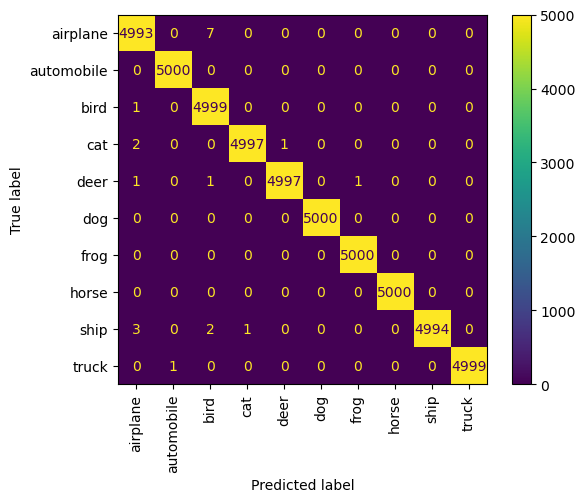

In [33]:
plot_confusion_matrix(model, X_train, y, labels=labels)

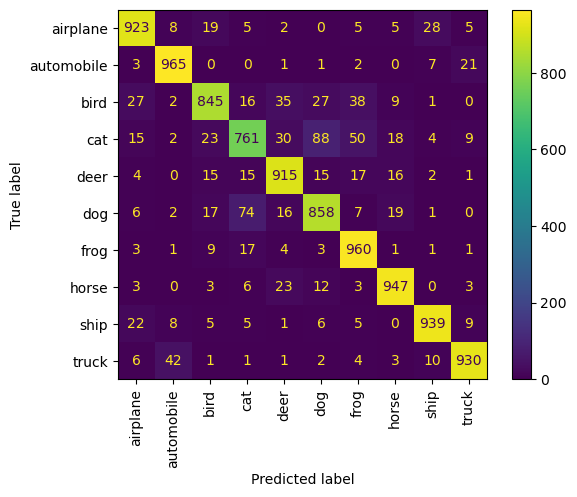

In [34]:
plot_confusion_matrix(model, X_test, y_test, labels=labels)

In [35]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.4744 - accuracy: 0.9043


[0.4743626117706299, 0.9042999744415283]